In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## Loading Data Then Train_Test_Spliting 

In [2]:
data1=pd.read_csv('data1.csv')
# Here I just continue without looking weather there is a missing values in features of data becaues after some basic analysis I make pipeline  where 
# I solve this problem inside pipeline before trainig model.

#All Feature Feature
# • crim: Per capita crime rate by town.
# • zn: Proportion of large residential lots (over 25,000 sq. ft.).
# • indus: Proportion of non-retail business acres per town.
# • chas: Binary variable indicating if the property is near Charles River (1 for yes, 0 for no).
# • nox: Concentration of nitrogen oxides in the air.
# • rm: Average number of rooms per dwelling.
# • age: Proportion of old owner-occupied units built before 1940.
# • dis: Weighted distances to Boston employment centers.
# • rad: Index of accessibility to radial highways.
# • tax: Property tax rate per $10,000.
# • ptratio: pupil-teacher ratio by town.
# • b: proportion of owner-occupied units built prior to 1940 or 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
# • lstat:%lower status of the population.
# • medv:median value of owner-occupied homes in $1000’s

#Train_Test Spliting of data1.
#Befor This Checking is there a Senstive Feature or not 

data1['chas'].value_counts() #This is Sensitve  So I used Stratified Spliting Instead of simple spliting

#Output:
# chas
# 0    471
# 1     35
# Name: count, dtype: int64

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.20,random_state=42)
for train_index,test_index in split.split(data1,data1["chas"]):
    train_set=data1.loc[train_index]
    test_set=data1.loc[test_index]
    
# from sklearn.model_selection import train_test_split

# train_set,test_set = train_test_split(data1,test_size=0.20,random_state=42)

#NOTE: These sets select randomly after shuffling data indices (random seed also fix)
#Check Size & More
# print(train_set.shape,test_set.shape)
# train_set['chas'].value_counts()
# test_set['chas'].value_counts()

## Corelation Analysis

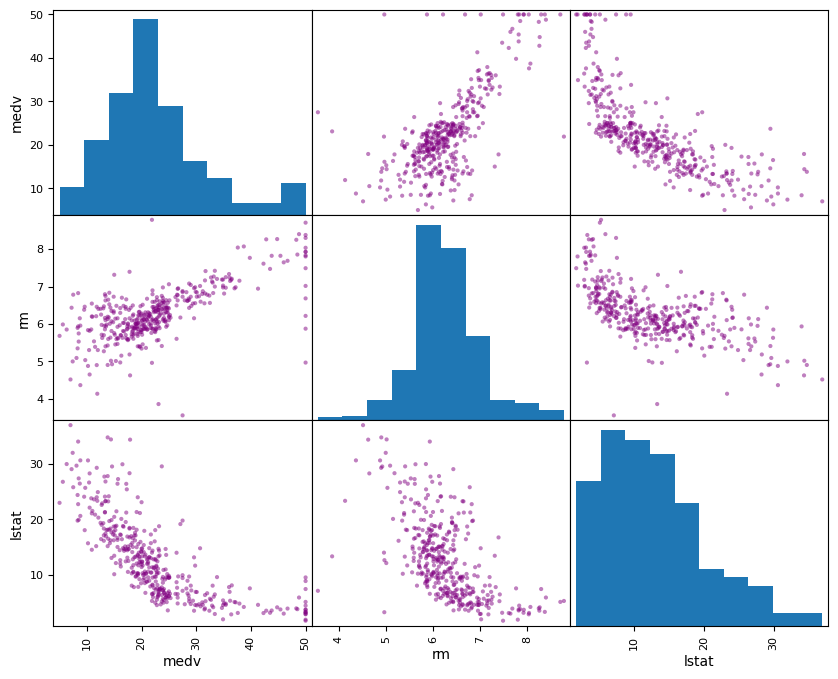

In [3]:
corr_matrix=train_set.corr()

corr_matrix['medv'].sort_values(ascending=False)
# rm is strong positve corelate while lstat is strong negtive corelate with price.

#lets plot these imported corelated feastures using pandas 

from pandas.plotting import scatter_matrix

imported_f = ['medv','rm','lstat']

scatter_matrix(train_set[imported_f],figsize=(10,8),color='purple')

#Outlier Exists Here in Both Important Features Later if Accurecey Bad Then I Try to reduce them

#Finally Before Making Pipeline Lets separate training data lables and features


training_set_features = train_set.drop(['medv'],axis=1)
training_set_lables = train_set['medv'].copy()

## Making Pipeline (Series of Steps)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
#I can add more functions if needed (Note Depend on Model Evaluation) 
my_pipeline  = Pipeline([
    ('imputer',SimpleImputer(strategy="median")), #We already do it manually.Just Filling Blanks
    #('pca', PCA(n_components=0.95)),
    #('poly_features', PolynomialFeatures(degree=2)), 
    #     ....add as many as you want in your pipeline
    ('std_scaler',StandardScaler())]) #Feature Scaling should be perform  at end it use his own transform_fit function
train_set_num_ar=my_pipeline.fit_transform(training_set_features)
train_set_num_ar.shape
#len(train_set_num_ar[:,5]) #Check filling is sucessfull or not but result: yes sucessfull

(404, 13)

## Desired Model Selection

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#model=LinearRegression()
#model=RandomForestRegressor()
model=GradientBoostingRegressor()

model.fit(train_set_num_ar,training_set_lables)

GradientBoostingRegressor()

In [6]:
#Lets Take a Quick Look
some_data = training_set_features.iloc[:5]
some_labels = training_set_lables.iloc[:5]
prepared_data = my_pipeline.transform(some_data)
model.predict(prepared_data)

array([22.27587227, 25.3910372 , 17.30053005, 23.45644865, 23.91807876])

In [7]:
some_labels_list=list(some_labels)
some_labels_list

[21.9, 24.5, 16.7, 23.1, 23.0]

In [8]:
from sklearn.metrics import mean_squared_error
training_set_features_predictions = model.predict(train_set_num_ar)
mse = mean_squared_error(training_set_lables, training_set_features_predictions)
rmse = np.sqrt(mse)
rmse

1.3649096690786684

## Cross Validation (Better Evaluation Technique)

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_set_num_ar, training_set_lables, scoring = "neg_mean_squared_error",cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([2.94764213, 2.70099362, 4.79264131, 2.29568803, 2.92848302,
       2.70379678, 3.70185717, 3.52273728, 2.71206247, 2.31776344])

In [10]:
def print_scores(scores):
    print("Scores:\n",scores)
    print("Mean:",scores.mean())
    print("Variance:",scores.var())
    print("Standard Deviation:",scores.std())
print_scores(rmse_scores)    

Scores:
 [2.94764213 2.70099362 4.79264131 2.29568803 2.92848302 2.70379678
 3.70185717 3.52273728 2.71206247 2.31776344]
Mean: 3.0623665258793666
Variance: 0.5169932065896234
Standard Deviation: 0.7190223964450784


## Anova Test

Anova Test is performed on another notebook by collecting the evaluation data. File is attach, also by applying this test I see  Gradient Boosting Regression and Rendom Forest Regression Models have significant difference from Linear Regression Model base on p_value come out by applying this test which are 0.002 and 0.006 respectively, much more less then 0.5 implies huge diffrence, Then based on Model_Evaluation.text file which contain follwing attributes for each model:

Simple_RMS: ........\
After_Cross_Validation:\
Scores:........\
Mean:........\
Variance:........\
Standard deviation:........

I reject Linear Regression Model. But when I apply anova test to compare Gradient Boosting Regression and Rendom Forest Regression Models p_value become 0.5 meant to say these models have not any difference between them. Then based on this situation I decide to select one model for Lunching and Implementation afte evaluate them on test data.

## Testing Model on Test_Set

In [11]:
#Now I am give testing data in this way 20%,40%,60%,80% and 100%
X_test = test_set.drop("medv",axis=1)
#X_test.shape
Y_test = test_set["medv"].copy()
X_test_20 = X_test.iloc[:round(len(X_test) * 0.20)]
X_test_40 = X_test.iloc[:round(len(X_test) * 0.40)]
X_test_60 = X_test.iloc[:round(len(X_test) * 0.60)]
X_test_80 = X_test.iloc[:round(len(X_test) * 0.80)]

Y_test_20 = Y_test.iloc[:round(len(X_test) * 0.20)]
Y_test_40 = Y_test.iloc[:round(len(X_test) * 0.40)]
Y_test_60 = Y_test.iloc[:round(len(X_test) * 0.60)]
Y_test_80 = Y_test.iloc[:round(len(X_test) * 0.80)]

#Now picup each in sequence

X_test_prepared = my_pipeline.transform(X_test)
final_predictions = model.predict(X_test_prepared)
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
#print(final_predictions,list(Y_test_20))
final_rmse

2.6127704782398506

## Lunch Model

I Select Gradient Boosting Regression Model for Lunching based on the Model_Performance.txt file which contain folowing attributes:

Final RMSE(Root Mean Square Error): when following percentage of test data applied. 
1. 20 % \
Random Forest Regression:........\
Gradient Boosting Regressor:........
2. 40 % \
.......... 
3. 60 % \
..........
4. 80 % \
..........
5. 100 % \
.........

For all Batches Gradient Boosting Regression Model have batter results.   

In [12]:
#This will be done after final model selction 
from joblib import dump, load
dump(model, 'CEP_Part1.joblib')

['CEP_Part1.joblib']

## Model Implmentation (Lunched Model)

In [13]:
#Sample
prepared_data[3]
#Coressponding actual label
some_labels_list[3]

23.1

In [14]:
from joblib import dump, load
import numpy as np
model = load('CEP_Part1.joblib')
Feature = np.array([[-0.42292925, -0.4898311 , -0.57719868, -0.27288841, -0.5573845 ,
        0.13688444, -0.52225911,  0.37882487, -0.5429938 , -0.74402708,
        0.52982668,  0.45343469, -0.81939807]]) #array from perpared_data[3] which is sample point basically
#Predicted Label 
model.predict(Feature)


array([23.45644865])